<a href="https://colab.research.google.com/github/chawonlee/AI_svm_mlp_deepmlp/blob/master/cat_and_dog_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import os
# 기본 경로
base_dir = '/content/drive/MyDrive/archive'

training_set = os.path.join(base_dir, 'training_set')
test_set = os.path.join(base_dir, 'test_set')

# 훈련에 사용되는 고양이/개 이미지 경로
training_set_cats = os.path.join(training_set, 'cats')
training_set_dogs = os.path.join(training_set, 'dogs')
print(training_set_cats)
print(training_set_dogs)

# 테스트에 사용되는 고양이/개 이미지 경로
test_set_cats = os.path.join(test_set, 'cats')
test_set_dogs = os.path.join(test_set, 'dogs')
print(test_set_cats)
print(test_set_dogs)

/content/drive/MyDrive/archive/training_set/cats
/content/drive/MyDrive/archive/training_set/dogs
/content/drive/MyDrive/archive/test_set/cats
/content/drive/MyDrive/archive/test_set/dogs


In [6]:
#이미지 개수 확인
print('Total training cat images :', len(os.listdir(training_set_cats)))
print('Total training dog images :', len(os.listdir(training_set_dogs)))

print('Total test cat images :', len(os.listdir(test_set_cats)))
print('Total test dog images :', len(os.listdir(test_set_dogs)))

Total training cat images : 4001
Total training dog images : 4016
Total test cat images : 1012
Total test dog images : 1013


In [7]:
#파일 이름 출력
training_set_cats_fnames = os.listdir( training_set_cats )
training_set_dogs_fnames = os.listdir( training_set_dogs )

print(training_set_cats_fnames[:5])
print(training_set_dogs_fnames[:5])

['cat.3698.jpg', 'cat.3669.jpg', 'cat.3685.jpg', 'cat.3683.jpg', 'cat.3684.jpg']
['dog.371.jpg', 'dog.3737.jpg', 'dog.370.jpg', 'dog.3704.jpg', 'dog.3736.jpg']


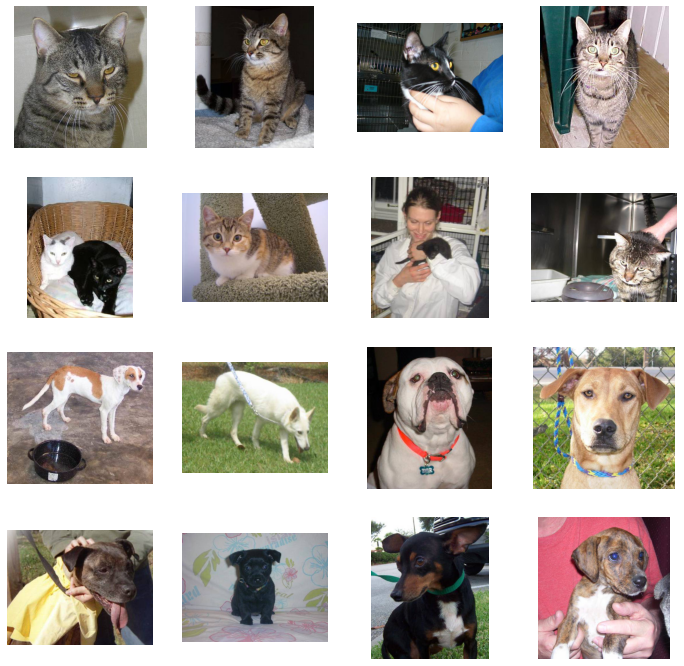

In [8]:
#데이터셋 출력
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

nrows, ncols = 4, 4
pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*3, nrows*3)

pic_index+=8

next_cat_pix = [os.path.join(training_set_cats, fname)
                for fname in training_set_cats_fnames[ pic_index-8:pic_index]]

next_dog_pix = [os.path.join(training_set_dogs, fname)
                for fname in training_set_dogs_fnames[ pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [9]:

!pip install python-resize-image
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image
from torchvision.datasets import ImageFolder
from resizeimage import resizeimage

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc, accuracy_score

In [10]:
# importing images using torchvision
dataset = ImageFolder("/content/drive/MyDrive/archive/training_set")
# creating labels dataframe
imgs, labels = zip(*dataset.imgs)
imgs = list(imgs)
labels = list(labels)
labels_df = pd.DataFrame({'image': imgs, 'label':labels})
labels_df


,image,label
0,/content/drive/MyDrive/archive/training_set/ca...,1
1,/content/drive/MyDrive/archive/training_set/ca...,1
2,/content/drive/MyDrive/archive/training_set/ca...,1
3,/content/drive/MyDrive/archive/training_set/ca...,1
4,/content/drive/MyDrive/archive/training_set/ca...,1
...,...,...
8010,/content/drive/MyDrive/archive/training_set/do...,2
8011,/content/drive/MyDrive/archive/training_set/do...,2
8012,/content/drive/MyDrive/archive/training_set/do...,2
8013,/content/drive/MyDrive/archive/training_set/do...,2


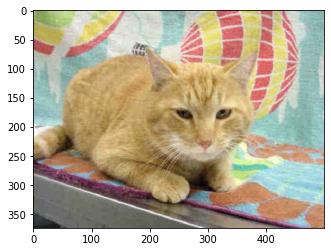

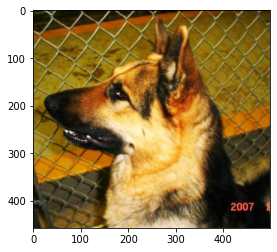

In [11]:
def get_image(path):
    img = Image.open(path)
    return np.array(img)

# showing a dog image
dog_row = labels_df[labels_df.label == 1].reset_index().image[23]
plt.imshow(get_image(dog_row))
plt.show()

# showing a cat image
cat_row = labels_df[labels_df.label == 2].reset_index().image[79]
plt.imshow(get_image(cat_row))
plt.show()

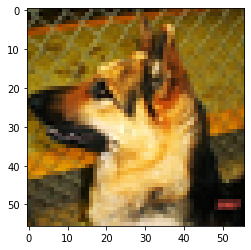

In [12]:
# image manupulation
img = Image.open(cat_row)
img = resizeimage.resize_cover(img, [56, 56])
plt.imshow(np.array(img), cmap='gray')
plt.show()

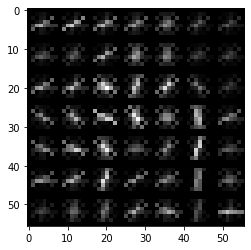

In [13]:
hog_features, hog_img = hog(img, visualize=True, block_norm='L2-Hys', pixels_per_cell=(8,8))
plt.imshow(np.array(hog_img), cmap='gray')
plt.show()

In [14]:
def create_features(path):
    img = Image.open(path)
    img = resizeimage.resize_cover(img, [56, 56])
    img_arr = np.array(img)
    # flatten three channel color image
    color_features = img_arr.flatten()
    # convert image to greyscale
    grey_image = rgb2grey(img_arr)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(8, 8))
    # combine color and hog features into a single array
    flat_features = np.hstack((color_features, hog_features))
    return flat_features

dog_features = create_features(dog_row)
print(dog_features.shape)

(11433,)


In [15]:
def create_feature_matrix(label_df):
    features_list = []
    
    for img_path in labels_df.image:
        # get features for image
        img_features = create_features(img_path)
        features_list.append(img_features)
    
    feature_matrix = np.array(features_list)
    return feature_matrix

feature_matrix = create_feature_matrix(labels_df)

In [16]:
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
imgs_stand = ss.fit_transform(feature_matrix)

Feature matrix shape is:  (8015, 11433)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(imgs_stand,
                                                    labels_df.label.values,
                                                    train_size=0.7,
                                                    )


In [24]:
svm = SVC(kernel='linear',gamma=0.001, probability=True)

# fit model
svm.fit(X_train, y_train)
# generate predictions
y_pred = svm.predict(X_test)

In [19]:
# calculate accuracy
accuracy = accuracy_score(y_pred, y_test)
print('svm 정확률 : ', accuracy*100)

svm 정확률 :  63.06924516531504


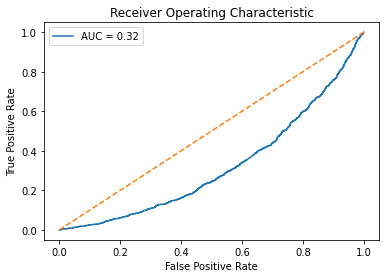

In [20]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

In [21]:
from random import randint

test = ImageFolder("/content/drive/MyDrive/archive/test_set")
imgs, labels = zip(*test.imgs)
imgs = list(imgs)
labels = list(labels)

예측: Cat
실제: Cat


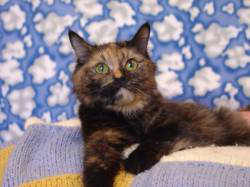

In [22]:
random_ix = randint(0, len(imgs))
label = {1: 'Cat', 2:'Dog'}
rand_img = imgs[random_ix]
# create features of the image
test_features = create_features(rand_img)
# predict
prediction = svm.predict([test_features])
print("예측: " + label[prediction[0]])
print("실제: " + label[labels[random_ix]])
# display image
display(Image.open(rand_img))